# Amazon Review Sentiment Analysis

### Marissa Shand (mes7jt), Cory Clayton (acc2ds), Michael Pajewski (mtp9k), Jordan Machita (jm8ux)

In [1]:
## Import statements
import pandas as pd
import numpy as np
import requests
import json
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, asc, desc
from pyspark.sql.types import *
from pyspark.sql.functions import ltrim,rtrim,trim
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.sql.functions import size, expr
from pyspark.mllib.evaluation import MulticlassMetrics

# Import the Data

For this project, we are using Amazon Grocery and Gourmet Food reviews. 

In [2]:
file_name = "/project/ds5559/Amazon_Data_DS5559_mtp9k/Grocery_and_Gourmet_Food.json"
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("Amazon Grocery Reviews").getOrCreate()
amazon_food = spark.read.json(file_name)
amazon_food.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Display Height:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Flavor Name:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Item Display Weight:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Material Type:: string (nullable = true)
 |    |-- Material:: string (nullable = true)
 |    |-- Number of Items:: string (nullable = true)
 |    |-- Package Quantity:: string (nulla

In [3]:
## Select the variables we are interested in
food = amazon_food.select("asin", "reviewerID", "reviewText", "summary", "reviewTime", "verified", "overall")

# Exploratory Data Analysis (EDA)

## Statistical Summary

In [4]:
## Number of records
print(f"Number of records: {food.count()}")

## Number of columns
print(f"\nNumber of columns: {len(food.columns)}")

Number of records: 5074160

Number of columns: 7


In [5]:
## Statistical summary of response variable
print("\nStatistical summary of response variable")
food.describe("overall").show()


Statistical summary of response variable
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|           5074160|
|   mean| 4.314708247276396|
| stddev|1.2493033560071545|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [6]:
## asin - product ID 
print("Statistical Summaries of Predictor Variables:")
print(f"Product ID (asin)")
print(f"{food.groupby(food.asin).count().count()} unique asin values")
food.groupby(food.asin).agg(F.count(food.asin).alias("count"), ((F.count(food.asin)/food.count())*100).alias("percentage")).sort(F.desc("count")).show(10)

## reviewerID - reviewer ID 
print(f"\nReviewer ID (reviewerID)")
print(f"{food.groupby(food.reviewerID).count().count()} unique values")
food.groupby(food.reviewerID).agg(F.count(food.reviewerID).alias("count"), (F.count(food.reviewerID)/food.count()*100).alias("percentage")).sort(F.desc("count")).show(10)

## reviewText - review text
print(f"\nReview Text (reviewText)")
print(f"{food.groupby(food.reviewText).count().count()} unique values")
food.groupby(food.reviewText).agg(F.count(food.reviewText).alias("count"), (F.count(food.reviewText)/food.count()*100).alias("percentage")).sort(F.desc("count")).show(10)

## summary - summary of review
print(f"\nSummary of Review (summary)")
print(f"{food.groupby(food['summary']).count().count()} unique values")
food.groupby(food['summary']).agg(F.count(food['summary']).alias("count"), (F.count(food['summary'])/food.count()*100).alias("percentage")).sort(F.desc("count")).show(10)

## reviewTime
print(f"\nReview Date (reviewTime)")
print(f"{food.groupby(food.reviewTime).count().count()} unique values")
food.groupby(food.reviewTime).agg(F.count(food.reviewTime).alias("count"), (F.count(food.reviewTime)/food.count()*100).alias("percentage")).sort(F.desc("count")).show(10)

## verified - verified user
print(f"\nVerified User (verified)")
print(f"{food.groupby(food.verified).count().count()} unique values")
food.groupby(food.verified).agg(F.count(food.verified).alias("count"), (F.count(food.verified)/food.count()*100).alias("percentage")).sort(F.desc("count")).show(10)

Statistical Summaries of Predictor Variables:
Product ID (asin)
283507 unique asin values
+----------+-----+-------------------+
|      asin|count|         percentage|
+----------+-----+-------------------+
|B00BUKL666|11526| 0.2271508978826052|
|B00542YXFW| 9083| 0.1790049978715689|
|B008QMX2SG| 8903|0.17545761268860266|
|B00D3M2QP4| 8880| 0.1750043356930014|
|B000YN2GVY| 7400| 0.1458369464108345|
|B000X3TPHS| 7310| 0.1440632538193514|
|B01E5XTW24| 7001|  0.137973575921926|
|B000F4DKAI| 6862|0.13523420625285762|
|B0001LO3FG| 6858|0.13515537547101392|
|B000EVMNMI| 6323|0.12461175839941979|
+----------+-----+-------------------+
only showing top 10 rows


Reviewer ID (reviewerID)
2695974 unique values
+--------------+-----+--------------------+
|    reviewerID|count|          percentage|
+--------------+-----+--------------------+
|  A1LACH6MLQWZ| 1103|0.021737588093398708|
|A1GQAKL9CGQLP1|  690|0.013598309868037272|
|A2GJX2KCUSR0EI|  588|0.011588124931023066|
|A2C9XE9I8RSKNX|  500| 0.0

## Graphical Summary

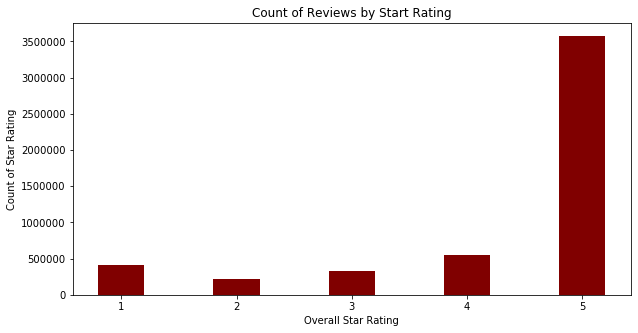

In [7]:
## Distribution of review stars 
## Group the dataframe by rating and convert to a pandas dataframe
Overall_scores = food.groupby(food.overall).count()
Overall_scores_df = Overall_scores.toPandas()

## Create a bar plot
fig = plt.figure(figsize = (10, 5))
plt.bar(Overall_scores_df['overall'], 
        Overall_scores_df['count'], 
        color ='maroon', 
        width = 0.4)
plt.xlabel("Overall Star Rating")
plt.ylabel("Count of Star Rating")
plt.title("Count of Reviews by Start Rating")
plt.show()

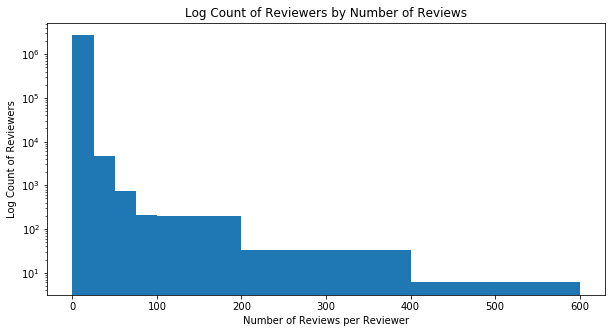

In [8]:
## Number of Reviews per Reviewer
## Groupby reviewer ID, then get average rating for that reviewer and their number of reviews 
## Then convert to pandas dataframe ans sort values 
reviewer_count = food.groupBy('reviewerID').agg(F.avg('overall'), F.count('overall'))
reviewer_count = reviewer_count.toPandas()
reviewer_count = reviewer_count.sort_values(by = ['count(overall)'], ascending = False)

## Create histogram
fig, ax = plt.subplots(figsize = (10, 5)) 
ax.hist(reviewer_count['count(overall)'], bins = [0, 25, 50, 75, 100, 200, 400, 600]) 
plt.xlabel("Number of Reviews per Reviewer")
plt.ylabel("Log Count of Reviewers")
plt.title("Log Count of Reviewers by Number of Reviews")
plt.yscale('log', nonposy = 'clip')
plt.show()

/home/mes7jt/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


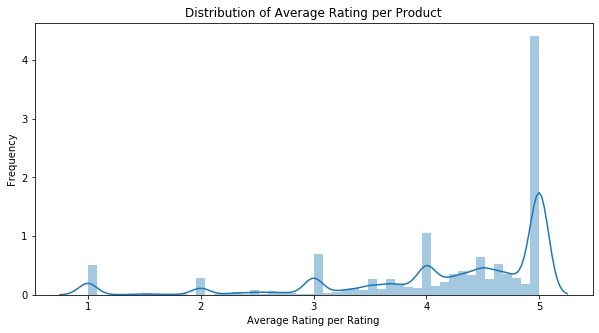

In [9]:
## KDE/Histogram of Product Average Rating
## Group by product ID and obtain average rating
## Then convert to pandas dataframe
prods = food.groupBy("asin").agg(F.avg("overall"))
df = prods.toPandas()

## kde/histogram of product average rating
plt.figure(figsize = (10, 5))
sns.distplot(df["avg(overall)"], kde = True)
plt.ylabel('Frequency')
plt.xlabel('Average Rating per Rating')
plt.title('Distribution of Average Rating per Product');

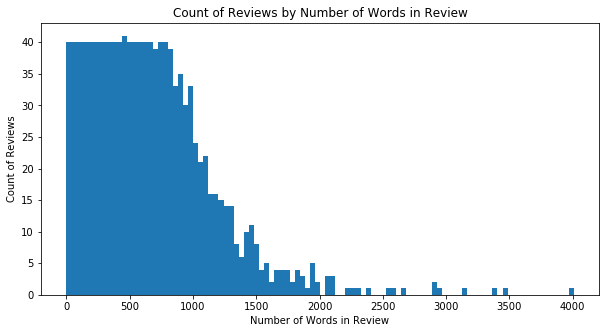

In [10]:
## How long are the reviews?
## Count number of words in the review
num_words = food.select(F.size(F.split(F.col("reviewText"), " ")).alias("num_words"))

## Groupby num_words and get count
grouped_num_words = num_words.groupby("num_words").count()

## Convert to pandas for plotting
num_words_df = grouped_num_words.toPandas()

## Plot using histogram
fig = plt.figure(figsize = (10, 5))
plt.hist(num_words_df["num_words"], bins = 100)
plt.xlabel("Number of Words in Review")
plt.ylabel("Count of Reviews")
plt.title("Count of Reviews by Number of Words in Review")
plt.show()

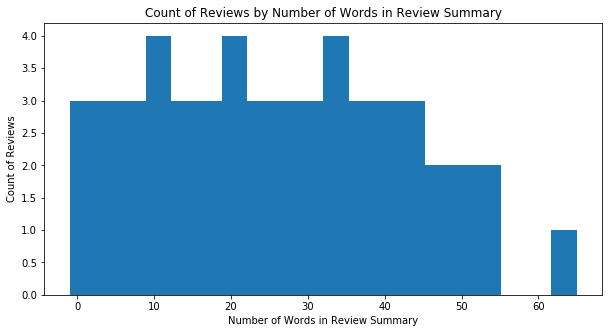

In [11]:
## How long are the review summaries?
## Count number of words in the review
num_words_sum = food.select(F.size(F.split(F.col("summary"), " ")).alias("num_words"))

## Groupby num_words and get count
grouped_num_words_sum = num_words_sum.groupby("num_words").count()

## Convert to pandas for plotting
num_words_sum_df = grouped_num_words_sum.toPandas()

## Plot using histogram
fig = plt.figure(figsize = (10, 5))
plt.hist(num_words_sum_df["num_words"], bins = 20)
plt.xlabel("Number of Words in Review Summary")
plt.ylabel("Count of Reviews")
plt.title("Count of Reviews by Number of Words in Review Summary")
plt.show()

# Data Preprocessing

In [4]:
## For our models, we will only be using the review text and the rating
flatten_amazon = amazon_food.select(['reviewText', 'overall'])

## Remove NA values
notnull_amazon = flatten_amazon.na.drop(subset=['reviewText', 'overall'])

## How many observations do we have now?
print(notnull_amazon.count())

## What does an observation look like?
notnull_amazon.take(1)

5071277


[Row(reviewText='Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It definitely will sparkle.', overall=5.0)]

In [5]:
## Change rating to a binary classification
## 1 = Positive
## 0 = Negative
## Chose to make 3 negative, because the user typically would not recommend a neutral product
def vibe(num):
    if num > 3.0:
        return 1
    else:
        return 0
    
## Create a spark function
func_udf = F.udf(vibe, IntegerType())

## Apply the binarization to our data
## Only keep the review text and the binary classification
data = notnull_amazon.withColumn('target', func_udf(col('overall'))).select(['reviewText', 'target'])

## What does the new data look like?
data.show(5)

+--------------------+------+
|          reviewText|target|
+--------------------+------+
|Very pleased with...|     1|
|Very nicely craft...|     1|
|still very pretty...|     1|
|I got this for ou...|     1|
|It was just what ...|     1|
+--------------------+------+
only showing top 5 rows



In [6]:
## How many positive and negative values do we have?
data.groupby('target').count().show()

+------+-------+
|target|  count|
+------+-------+
|     1|4124647|
|     0| 946630|
+------+-------+



In [7]:
## Remove punctuation and convert the review text to lower case
## https://stackoverflow.com/questions/53218312/pyspark-how-to-remove-punctuation-marks-and-make-lowercase-letters-in-rdd
def lower_clean_str(x):    
    ## Convert string to lowercase
    lowercased_str = x.lower()
    
    ## Create a string of punctuation
    punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    
    ## Remove punctuation from the string
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str

## Apply the function to our dataset
lower_func = F.udf(lower_clean_str, StringType())
data = data.withColumn('reviewClean', lower_func(col('reviewText')))

## Trim white space off the ends of the review
## https://analyticshut.com/removing-white-spaces-in-spark/
data = data.select(trim(col("reviewClean")).alias("reviewClean"), "target")

## Show the data
data.show(5)

+--------------------+------+
|         reviewClean|target|
+--------------------+------+
|very pleased with...|     1|
|very nicely craft...|     1|
|still very pretty...|     1|
|i got this for ou...|     1|
|it was just what ...|     1|
+--------------------+------+
only showing top 5 rows



# Split the Data

In [8]:
(train_set, test_set) = data.randomSplit([0.90, 0.10], seed = 314)

In [9]:
## Tokenize the data
tokenizer = Tokenizer(inputCol="reviewClean", outputCol="words")

## Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

## Get term frequency
hashtf = HashingTF(numFeatures=2**16, inputCol="filtered", outputCol='tf')

## Get the inverse document frequency
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5)

## Create a pipeline for TF-IDF
pipeline = Pipeline(stages=[tokenizer, remover, hashtf, idf])

## Fit the pipeline on the date
pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
test_df = pipelineFit.transform(test_set)
train_df.show(5)

+-----------+------+-----+--------+--------------------+--------------------+
|reviewClean|target|words|filtered|                  tf|            features|
+-----------+------+-----+--------+--------------------+--------------------+
|           |     0|   []|      []|(65536,[52572],[1...|(65536,[52572],[1...|
|           |     0|   []|      []|(65536,[52572],[1...|(65536,[52572],[1...|
|           |     0|   []|      []|(65536,[52572],[1...|(65536,[52572],[1...|
|           |     1|   []|      []|(65536,[52572],[1...|(65536,[52572],[1...|
|           |     1|   []|      []|(65536,[52572],[1...|(65536,[52572],[1...|
+-----------+------+-----+--------+--------------------+--------------------+
only showing top 5 rows



In [10]:
## Filter to obtain rows that are not empty
## The empty lists are actually [''], so we need to convert this to [], then can remove empty lists
## https://stackoverflow.com/questions/64355465/remove-empty-strings-from-list-in-dataframe-column
## https://stackoverflow.com/questions/55461843/filter-only-not-empty-arrays-dataframe-spark
train_df = train_df.withColumn("words", expr("filter(words, elem -> elem != '')")).filter(size("words") > 0).select(['reviewClean', 'words', 'tf', 'features', 'target'])
test_df = test_df.withColumn("words", expr("filter(words, elem -> elem != '')")).filter(size("words") > 0).select(['reviewClean', 'words', 'tf', 'features', 'target'])

## If you want to see the entire column, you can do train_df.show(5, False)
train_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+
|         reviewClean|               words|                  tf|            features|target|
+--------------------+--------------------+--------------------+--------------------+------+
|

3599 with free ...|[3599, with, free...|(65536,[614,1930,...|(65536,[614,1930,...|     1|
|

celestial seaso...|[celestial, seaso...|(65536,[48,86,614...|(65536,[48,86,614...|     1|
|

celestial seaso...|[celestial, seaso...|(65536,[809,908,1...|(65536,[809,908,1...|     1|
|

celestial seaso...|[celestial, seaso...|(65536,[809,908,1...|(65536,[809,908,1...|     1|
|

dry desert lime...|[dry, desert, lim...|(65536,[2026,2502...|(65536,[2026,2502...|     1|
+--------------------+--------------------+--------------------+--------------------+------+
only showing top 5 rows



In [11]:
## Downsample training only
def downsample(df, target, positive_label, negative_label):
    """
    df              spark dataframe
    target          str, target variable
    positive_label  int, value of positive label
    negative_label  int, value of negative label
    """
    pos_c = df.filter(col(target) == positive_label).count()
    neg_c = df.filter(col(target) == negative_label).count()
    if pos_c >= neg_c:
        pos = neg_c/pos_c
        df_b = df.sampleBy(target, fractions={negative_label:1.0, positive_label:pos}, seed=314)
    else:
        neg = pos_c/neg_c
        df_b = df.sampleBy(target, fractions={negative_label:neg, positive_label:1.0}, seed=314)
    return df_b

## Apply downsampling to our dataset
target = 'target'
positive_label = 1
negative_label = 0
train_df = downsample(train_df, target, positive_label, negative_label)
train_df.groupby('target').count().show()

+------+------+
|target| count|
+------+------+
|     1|852456|
|     0|851570|
+------+------+



In [12]:
## When response was not called 'label', we got an error during model construction
train_df = train_df.withColumnRenamed('target', 'label')
test_df = test_df.withColumnRenamed('target', 'label')

# Model Construction and Evaluation

In this section, we will construct three models, a logistic regression model, random forest classifier, and gradient boosted tree classifier. We chose not to use pyspark.mllib.evaluation.MulticlassMetrics to obtain the accuracy, precision, recall, and f1 measure because it only printed out accuracy instead of printing precision, recall, and f1. Instead, we calculate these metrics directly from the confusion matrix.

## Logistic Regression

### First Implementation of Logistic Regression

In [26]:
from pyspark.ml.classification import LogisticRegression
import time
t0 = time.time()

## Fit a logistic regression model on the training data
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'label',
                        maxIter = 100)
lrModel = lr.fit(train_df)

## Create predictions on the test set
lr_predictions = lrModel.transform(test_df)

## Convert these predictions to an rdd
lr_predictions = lr_predictions.select(['label', 'prediction']).rdd.map(tuple).map(lambda x: (float(x[1]), float(x[0])))

In [27]:
## Obtain metrics for the logistic regression model
lr_metrics = MulticlassMetrics(lr_predictions)

## Confusion Matrix
lr_cm = lr_metrics.confusionMatrix().toArray()
print(f"Confusion Matrix: \n{lr_cm}")

## Confusion matrix cells
tn = lr_cm[0][0]
fp = lr_cm[0][1]
fn = lr_cm[1][0]
tp = lr_cm[1][1]
total = tn + fp + fn + tp

## Accuracy
lr_accuracy = (tp + tn)/(total)
print(f"Accuracy: {lr_accuracy}")

## Precision
lr_precision = tp / (tp + fp)
print(f"Precision: {lr_precision}")

## Recall
lr_recall = tp / (tp + fn)
print(f"Recall: {lr_recall}")

## F1
lr_f1 = 2*(lr_precision*lr_recall)/(lr_precision+lr_recall)
print(f"F1 Measure: {lr_f1}")

## Print time it took to run logistic regression section
print("Logistic regression time:", time.time() - t0)

Confusion Matrix: 
[[ 80819.  14180.]
 [ 52180. 359387.]]
Accuracy: 0.8690002882151585
Precision: 0.9620416150248817
Recall: 0.8732162685540872
F1 Measure: 0.9154793958738252
Logistic regression time: 353.5326597690582


### Logistic Regression with CrossValidator

In [28]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
new_lr = LogisticRegression(featuresCol = 'features',
                           labelCol = 'label',
                           fitIntercept = True,
                           maxIter = 100)

paramGrid = ParamGridBuilder() \
    .addGrid(new_lr.regParam, [0.0, 0.01, 0.1]) \
    .addGrid(new_lr.threshold, [0.4, 0.5, 0.6]) \
    .build()

crossval = CrossValidator(estimator=new_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

import time
t0 = time.time()
cvModel = crossval.setParallelism(4).fit(train_df) # train 4 models in parallel
print("Train time:", time.time() - t0)

Train time: 1948.5248761177063


In [33]:
## Create predictions on the test set
lr_predictions = cvModel.bestModel.transform(test_df)

## Convert these predictions to an rdd
lr_predictions = lr_predictions.select(['label', 'prediction']).rdd.map(tuple).map(lambda x: (float(x[1]), float(x[0])))

## Obtain metrics for the logistic regression model
lr_metrics = MulticlassMetrics(lr_predictions)

## Confusion Matrix
lr_cm = lr_metrics.confusionMatrix().toArray()
print(f"Confusion Matrix: \n{lr_cm}")

## Confusion matrix cells
tn = lr_cm[0][0]
fp = lr_cm[0][1]
fn = lr_cm[1][0]
tp = lr_cm[1][1]
total = tn + fp + fn + tp

## Accuracy
lr_accuracy = (tp + tn)/(total)
print(f"Accuracy: {lr_accuracy}")

## Precision
lr_precision = tp / (tp + fp)
print(f"Precision: {lr_precision}")

## Recall
lr_recall = tp / (tp + fn)
print(f"Recall: {lr_recall}")

## F1
lr_f1 = 2*(lr_precision*lr_recall)/(lr_precision+lr_recall)
print(f"F1 Measure: {lr_f1}")

Confusion Matrix: 
[[ 67156.  27843.]
 [ 23309. 388258.]]
Accuracy: 0.8990220425373989
Precision: 0.9330859574958964
Recall: 0.9433652357939291
F1 Measure: 0.9381974414861998


In [34]:
print(cvModel.bestModel._java_obj.getRegParam())
print(cvModel.bestModel._java_obj.getThreshold())

0.1
0.4


## Random Forest Classifier

### First Implementation of Random Forest

In [35]:
from pyspark.ml.classification import RandomForestClassifier
t0 = time.time()

## Fit a random forest classifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_df)

## Create predictions on the test set
rf_predictions = rfModel.transform(test_df)

## Convert these predictions to an rdd
rf_predictions = rf_predictions.select(['label', 'prediction']).rdd.map(tuple).map(lambda x: (float(x[1]), float(x[0])))

In [36]:
## Obtain metrics for the logistic regression model
rf_metrics = MulticlassMetrics(rf_predictions)

## Confusion Matrix
rf_cm = rf_metrics.confusionMatrix().toArray()
print(f"Confusion Matrix: \n{rf_cm}")

## Confusion matrix cells
tn = rf_cm[0][0]
fp = rf_cm[0][1]
fn = rf_cm[1][0]
tp = rf_cm[1][1]
total = tn + fp + fn + tp

## Accuracy
rf_accuracy = (tp + tn)/(total)
print(f"Accuracy: {rf_accuracy}")

## Precision
rf_precision = tp / (tp + fp)
print(f"Precision: {rf_precision}")

## Recall
rf_recall = tp / (tp + fn)
print(f"Recall: {rf_recall}")

## F1
rf_f1 = 2*(rf_precision*rf_recall)/(rf_precision+rf_recall)
print(f"F1 Measure: {rf_f1}")

## Print time it took to run random forest section
print("Random forest time:", time.time() - t0)

Confusion Matrix: 
[[ 54671.  40328.]
 [ 85159. 326408.]]
Accuracy: 0.752279071236522
Precision: 0.8900353387723049
Recall: 0.7930859374050884
F1 Measure: 0.8387684487917946
Random forest time: 1498.8579785823822


### Random Forest with CrossValidator

In [13]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time
from pyspark.ml.classification import RandomForestClassifier
new_rf = RandomForestClassifier(featuresCol = 'features',
                           labelCol = 'label')

paramGrid = ParamGridBuilder() \
    .addGrid(new_rf.maxDepth, [5, 8, 10]) \
    .addGrid(new_rf.numTrees, [10, 20, 30]) \
    .build()

crossval = CrossValidator(estimator=new_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

import time
t0 = time.time()
cvModel = crossval.setParallelism(4).fit(train_df) # train 4 models in parallel
print("Train time:", time.time() - t0)

Train time: 19720.568876743317


In [14]:
## Create predictions on the test set
lr_predictions = cvModel.bestModel.transform(test_df)

## Convert these predictions to an rdd
lr_predictions = lr_predictions.select(['label', 'prediction']).rdd.map(tuple).map(lambda x: (float(x[1]), float(x[0])))

## Obtain metrics for the logistic regression model
lr_metrics = MulticlassMetrics(lr_predictions)

## Confusion Matrix
lr_cm = lr_metrics.confusionMatrix().toArray()
print(f"Confusion Matrix: \n{lr_cm}")

## Confusion matrix cells
tn = lr_cm[0][0]
fp = lr_cm[0][1]
fn = lr_cm[1][0]
tp = lr_cm[1][1]
total = tn + fp + fn + tp

## Accuracy
lr_accuracy = (tp + tn)/(total)
print(f"Accuracy: {lr_accuracy}")

## Precision
lr_precision = tp / (tp + fp)
print(f"Precision: {lr_precision}")

## Recall
lr_recall = tp / (tp + fn)
print(f"Recall: {lr_recall}")

## F1
lr_f1 = 2*(lr_precision*lr_recall)/(lr_precision+lr_recall)
print(f"F1 Measure: {lr_f1}")

Confusion Matrix: 
[[ 59251.  35748.]
 [ 65401. 346166.]]
Accuracy: 0.800324143349534
Precision: 0.9063977754154077
Recall: 0.8410927017958194
F1 Measure: 0.8725249879959319


In [16]:
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getNumTrees())

10
30


## Gradient Boosted Tree (GBT) Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier
import time
t0 = time.time()

## Fit a gradient boosted tree classifier
gbt = GBTClassifier(maxDepth = 5, maxIter = 20)
gbtModel = gbt.fit(train_df)

## Create predictions on the test set
gbt_predictions = gbtModel.transform(test_df)

## Convert these predictions to an rdd
gbt_predictions = gbt_predictions.select(['label', 'prediction']).rdd.map(tuple).map(lambda x: (float(x[1]), float(x[0])))

In [ ]:
## Obtain metrics for the logistic regression model
gbt_metrics = MulticlassMetrics(gbt_predictions)

## Confusion Matrix
gbt_cm = gbt_metrics.confusionMatrix().toArray()
print(f"Confusion Matrix: \n{gbt_cm}")

## Confusion matrix cells
tn = gbt_cm[0][0]
fp = gbt_cm[0][1]
fn = gbt_cm[1][0]
tp = gbt_cm[1][1]
total = tn + fp + fn + tp

## Accuracy
gbt_accuracy = (tp + tn)/(total)
print(f"Accuracy: {gbt_accuracy}")

## Precision
gbt_precision = tp / (tp + fp)
print(f"Precision: {gbt_precision}")

## Recall
gbt_recall = tp / (tp + fn)
print(f"Recall: {gbt_recall}")

## F1
gbt_f1 = 2*(gbt_precision*gbt_recall)/(gbt_precision+gbt_recall)
print(f"F1 Measure: {gbt_f1}")

## Print time it took to run random forest section
print("GBT time:", time.time() - t0)

**The code for GBT was run in a separate notebook but produced the following results:**

**Confusion Matrix:**

 82694   12305
 
180484  231083



**Accuracy:** 0.6194198

**Precision:** 0.9494429

**Recall:** 0.56147116

**F1 Measure:** 0.70564543

# Summary of Metrics

|Metric|Accuracy|Recall|Precision|F1|
|---|---|---|---|---|
|**Logistic Regression**|0.899|0.943|0.933|0.938|
|**Random Forest**|0.800|0.841|0.906|0.872|
|**Gradient Boosted Trees**|0.619|0.561|0.949|0.706|